In [27]:
# standard library imports
import csv
import ast
import datetime as dt
import json
import os
import statistics
import time

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# third-party imports
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import requests
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

### Reading data

In [7]:
sample_data = pd.read_csv('sample.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [8]:
print("\n Train Data:")
display(train_data.head(5))

print("\n Test Data:")
display(test_data.head(5))

print("\n Sample Data:")
display(sample_data.head(5))



 Train Data:


,date,u10,v10,u100,v100,production
0,2020-01-01 01:00:00,2.124600,-2.681966,2.864280,-3.666076,0.000000
1,2020-01-01 02:00:00,2.521695,-1.796960,3.344859,-2.464761,0.054879
2,2020-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,0.110234
3,2020-01-01 04:00:00,2.457504,-0.143642,3.215233,-0.355546,0.165116
4,2020-01-01 05:00:00,2.245898,0.389576,2.957678,0.332701,0.156940



 Test Data:


,date,u10,v10,u100,v100
0,2021-01-01 00:00:00,3.103149,1.295629,4.146771,1.672058
1,2021-01-01 01:00:00,3.456026,1.799494,4.624995,2.329869
2,2021-01-01 02:00:00,3.716234,1.893639,4.987532,2.435546
3,2021-01-01 03:00:00,4.029650,2.195310,5.442522,2.855735
4,2021-01-01 04:00:00,4.200922,2.402018,5.703258,3.147100



 Sample Data:


,date,production
0,2021-01-01 00:00:00,0.25
1,2021-01-01 01:00:00,0.25
2,2021-01-01 02:00:00,0.25
3,2021-01-01 03:00:00,0.25
4,2021-01-01 04:00:00,0.25


Explanation (https://www.kaggle.com/competitions/ensimag-wpf-2023/data): 
<br>
- date: Self-explanatory. <br>
- u10: Forecast zonal wind velocity (m/s) at 10m above ground. <br>
- v10: Forecast meridional wind velocity (m/s) at 10m above ground. <br>
- u100: Forecast zonal wind velocity (m/s) at 100m above ground. <br>
- v100: Forecast meridional wind velocity (m/s) at 100m above ground.  <br>
- production: Hourly-mean wind power normalised by the maximum output of the wind farm. 

In [8]:
## Check if found nan
print(train_data.isnull().values.any())

print(test_data.isnull().values.any())

False
False


## Describe and Summary

In [11]:
print("\n Train Summary:")
display(train_data.describe())


 Train Summary:


,u10,v10,u100,v100,production
count,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000
mean,0.964557,-0.082029,1.610435,-0.239035,0.296267
std,2.512513,2.917939,4.158947,5.012805,0.282242
min,-7.494252,-9.993858,-10.910809,-15.294866,0.000000
25%,-1.027461,-2.213298,-1.628854,-4.252406,0.055267
50%,0.838357,0.270344,1.527967,0.687264,0.204210
75%,2.550258,2.029854,4.617410,3.658531,0.500000
max,11.117029,9.508798,16.988418,14.314416,0.999530


In [12]:
print("\n Test Summary:")
display(test_data.describe())


 Test Summary:


,u10,v10,u100,v100
count,7982.000000,7982.000000,7982.000000,7982.000000
mean,0.914557,-0.435730,1.543345,-0.899533
std,2.600795,2.912914,4.373731,5.025452
min,-6.182938,-9.053481,-9.909989,-14.890407
25%,-1.082260,-2.470578,-1.866035,-4.852942
50%,0.746941,-0.375215,1.466632,-0.548208
75%,2.633750,1.809160,4.810936,3.232646
max,10.967380,7.454590,16.732868,10.977636


### Features Engineering - Getting production

In [2]:
train_data_date = pd.concat([x for x in pd.read_csv('train.csv',
                                              parse_dates=['date'],
                                              chunksize=1000)], ignore_index=True)

train_data_date['production'] = pd.to_numeric(train_data_date['production'], errors="coerce")
## For Testing

In [7]:
## Checking distribution of date
test_date = pd.concat([x for x in pd.read_csv('test.csv',
                                              parse_dates=['date'],
                                              chunksize=1000)])

train_data_date['date'] = pd.to_datetime(train_data_date['date'])

<Axes: xlabel='production', ylabel='Count'>

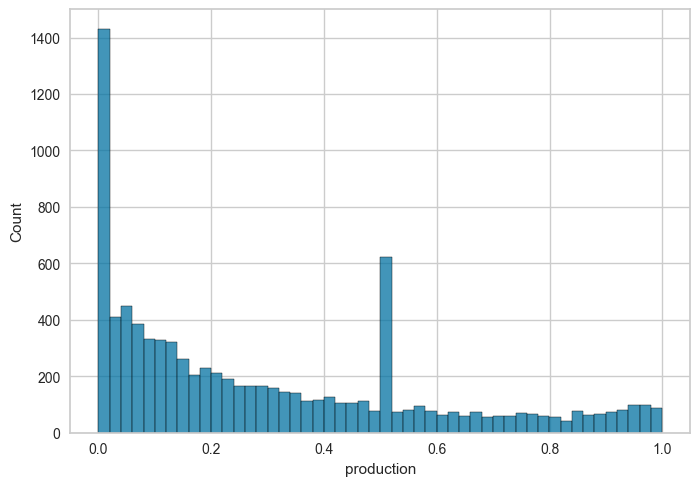

In [8]:
## Distribution of production
# Divided into 50 bins/intervals
sns.histplot(train_data_date['production'], bins=50)

### Trend

In [10]:
average_production = train_data_date.groupby('date').mean('production')

In [3]:
average_production_by_date = train_data_date.groupby('date').mean('production')['production']

In [21]:
plot_params = {'color': '0.75','style': '.-','markeredgecolor': '0.25','markerfacecolor': '0.25','legend': False}

In [31]:
#  Plot: Overall Sales Trend Over Time
# trend = average_sale.rolling(
#     window=365,
#     center=True,
#     min_periods=183,
# ).mean()


fig = px.scatter(title="Trend of Overall Production",data_frame=average_production_by_date, x=average_production_by_date.index, y=average_production_by_date.values, trendline="rolling", trendline_options=dict(window=365))
fig.data[1].update(line_color='red') 
fig.update_layout(
    xaxis_title="Time", yaxis_title="Production"
)
fig.show()

### Using matplotlib
# plt.plot(average_sale.index, average_sale.values)
# plt.xlabel("Time",  size = 20)
# plt.ylabel("Sales", size = 20)
# plt.title("Trend Sales", size = 25)

# plt.plot(trend, color="red")

### Training Model

In [9]:
train_data['date'] = pd.to_datetime(train_data['date'])

## Feature Engineering
train_data['day'] = train_data['date'].dt.day
train_data['month'] = train_data['date'].dt.month
train_data['year'] = train_data['date'].dt.year
train_data['dayofweek'] = train_data['date'].dt.dayofweek

#### Features and target of the predictive model

In [10]:
features = ['day', 'month', 'year', 'dayofweek']
target = ['production']


# drop all rows with missing values from both features and target
train_data.dropna(subset=features+target, inplace=True)

### Train test splitting

In [20]:
test_data['date'] = pd.to_datetime(test_data['date'])

## Feature Engineering
test_data['day'] = test_data['date'].dt.day
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year
test_data['dayofweek'] = test_data['date'].dt.dayofweek
# test_data['weekofyear'] = test_data['date'].dt.isocalendar().week

# Merge external oil data:
# Remove all missing values
test_data.ffill(inplace=True)

test_data.head()

,date,u10,v10,u100,v100,day,month,year,dayofweek
0,2021-01-01 00:00:00,3.103149,1.295629,4.146771,1.672058,1,1,2021,4
1,2021-01-01 01:00:00,3.456026,1.799494,4.624995,2.329869,1,1,2021,4
2,2021-01-01 02:00:00,3.716234,1.893639,4.987532,2.435546,1,1,2021,4
3,2021-01-01 03:00:00,4.029650,2.195310,5.442522,2.855735,1,1,2021,4
4,2021-01-01 04:00:00,4.200922,2.402018,5.703258,3.147100,1,1,2021,4


In [18]:
# Standard splitting will be used (20% of data will be used for validation, 80% for training)
np.random.seed(0)
X_train, X_val, y_train, y_val = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=4)

xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, early_stopping_rounds=50)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)


[0]	validation_0-rmse:0.27994
[50]	validation_0-rmse:0.21060
[100]	validation_0-rmse:0.19221
[150]	validation_0-rmse:0.18568
[200]	validation_0-rmse:0.18274
[250]	validation_0-rmse:0.18147
[300]	validation_0-rmse:0.18101
[350]	validation_0-rmse:0.18096
[400]	validation_0-rmse:0.18102
[415]	validation_0-rmse:0.18109


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
result_data = test_data

result_data['production'] = np.maximum(xgb_model.predict(result_data[features]), 0)

In [22]:
print("\n Result Data:")
display(result_data.head(5))


 Result Data:


,date,u10,v10,u100,v100,day,month,year,dayofweek,production
0,2021-01-01 00:00:00,3.103149,1.295629,4.146771,1.672058,1,1,2021,4,0.332664
1,2021-01-01 01:00:00,3.456026,1.799494,4.624995,2.329869,1,1,2021,4,0.332664
2,2021-01-01 02:00:00,3.716234,1.893639,4.987532,2.435546,1,1,2021,4,0.332664
3,2021-01-01 03:00:00,4.029650,2.195310,5.442522,2.855735,1,1,2021,4,0.332664
4,2021-01-01 04:00:00,4.200922,2.402018,5.703258,3.147100,1,1,2021,4,0.332664


## prediction Trend

In [24]:
predicted_average_production_by_date = test_data.groupby('date').mean('production')['production']

In [29]:

fig2 = px.scatter(title="Trend of Overall Predicted Wind Production",data_frame=predicted_average_production_by_date, x=predicted_average_production_by_date.index, y=predicted_average_production_by_date.values, trendline="rolling", trendline_options=dict(window=365))
fig2.data[1].update(line_color='red') 
fig2.update_layout(
    xaxis_title="Time", yaxis_title="Production"
)
fig.show()

### Joined Plot of trend

In [32]:
joinedFig = go.Figure(data = fig.data + fig2.data)
joinedFig.show()